In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///./Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first().date
recent_date

'2017-08-23'

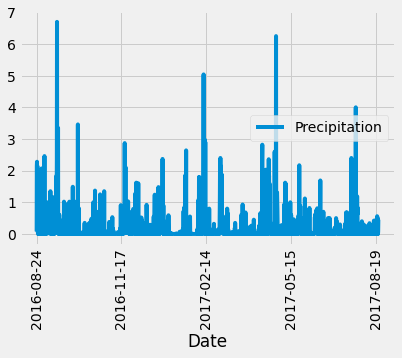

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
one_year_ago = dt.datetime.strptime(recent_date, '%Y-%m-%d')-dt.timedelta(days=365)
one_year_ago
# Perform a query to retrieve the data and precipitation scores
data_precip = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= one_year_ago).\
    order_by(measurement.date).all()
data_precip
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(data_precip, columns=['Date','Precipitation'])
precip_df.set_index('Date', inplace=True)
precip_df = precip_df.dropna()
precip_df

# Sort the dataframe by date
#As Above/Already Sorted
# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(rot=90)
plt.savefig("./Precipitation_last_12months.png")
plt.show()


In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number stations in the dataset
total_station = session.query(station)
print("There are {} stations.".format(total_station.count()))

There are 9 stations.


In [14]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
most_active = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
# most_active

most_active_name = ""
most_active_station = most_active[0][0]

for location in total_station:
        if(location.station == most_active[0][0]):
            most_active_name = location.name
print(f"The most active station info:")
print(f"Name   : {most_active_name}")
print(f"Station : {most_active[0][0]}")
print(f"Count : {most_active[0][1]}")
print("")
print('Stations in Descending Order')
print('----------------------------')
for most_active in most_active:
    print(most_active[0],"  ",most_active[1])


The most active station info:
Name   : WAIHEE 837.5, HI US
Station : USC00519281
Count : 2772

Stations in Descending Order
----------------------------
USC00519281    2772
USC00519397    2724
USC00513117    2709
USC00519523    2669
USC00516128    2612
USC00514830    2202
USC00511918    1979
USC00517948    1372
USC00518838    511


In [20]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
min_high_avg = session.query(func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs)).\
    filter(measurement.station == most_active_station).all()
# min_high_avg
print(f"The Low, High, & Average Temp for {most_active_station} is:")
print(f" Low : {min_high_avg[0][0]}")
print(f" High : {min_high_avg[0][1]}")
print(f" Average : {min_high_avg[0][2]}")

The Low, High, & Average Temp for USC00519281 is:
 Low : 54.0
 High : 85.0
 Average : 71.66378066378067


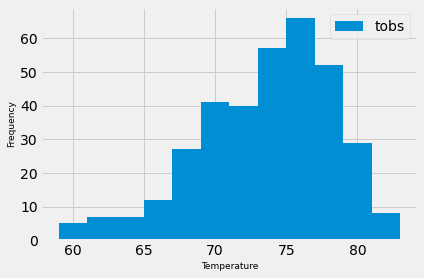

In [28]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_last_year = session.query(measurement.date, measurement.tobs).\
    filter(measurement.station == most_active_station).filter(measurement.date >= one_year_ago).\
    group_by(measurement.date).all()
active_last_year

#Df Set Up
active_last_year_df = pd.DataFrame(data=active_last_year, columns=["date","tobs"])
active_last_year_df = active_last_year_df.set_index('date',drop=True)
active_last_year_df

#Histogram Plot
plt.hist(active_last_year_df['tobs'],12,label="tobs")
plt.ylabel("Frequency", fontsize=9)
plt.xlabel("Temperature", fontsize=9)
plt.legend()
plt.savefig("./Histogram_Most_Active_Tobs_12Months.png")
plt.show()

# Close session

In [29]:
# Close Session
session.close()